In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
sys.path.append(os.path.abspath(os.path.join('..')))
from problems import ThreeHump_stochastic_hits, Rosenbrock_stochastic_hits, HelicalValley_stochastic_hits

In [2]:
problem = Rosenbrock_stochastic_hits()

phi_optimal = torch.tensor([1.0, 1.0])
phi_bad = torch.tensor([-1.9, -1.0])

y_optimal = problem.loss(phi_optimal).item()
y_bad = problem.loss(phi_bad).item()

In [3]:
problem.normalize_factor

1.0

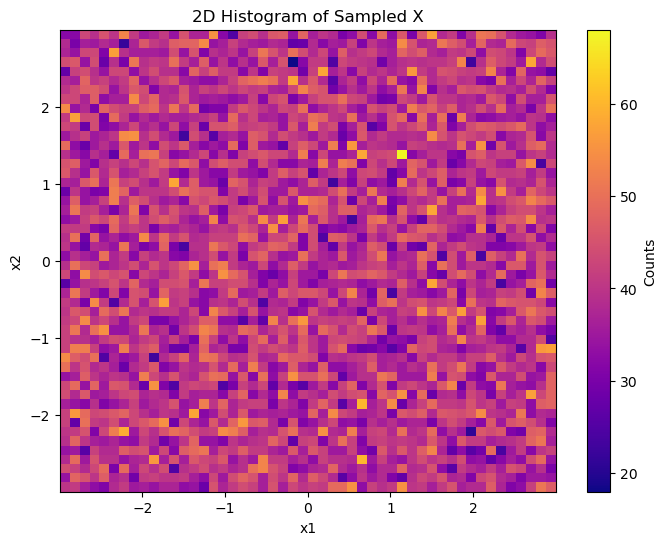

In [4]:
# Sample X using the problem's sample_x method
X_sample = problem.sample_x()

# Plot a 2D histogram of the sampled X values
plt.figure(figsize=(8, 6))
plt.hist2d(X_sample[:, 0].cpu().numpy(), X_sample[:, 1].cpu().numpy(), bins=50, cmap='plasma')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D Histogram of Sampled X')
plt.colorbar(label='Counts')
plt.show()

In [5]:
x_bounds = (-5, 5)
xx1 = torch.linspace(*x_bounds, 200)
xx1, xx2 = torch.meshgrid(xx1, xx1, indexing='ij')
X_vis = torch.stack([xx1.reshape(-1), xx2.reshape(-1)], dim=1)

bounds = problem.GetBounds()
pp1 = torch.linspace(*bounds[:, 0], 100)
pp2 = torch.linspace(*bounds[:, 1], 100)
pp1, pp2 = torch.meshgrid(pp1, pp2, indexing='ij')

Generating visualization of the sensitivity map s(X, PHI)...
Generating visualization of the 'Hit Zone' for different PHI values...


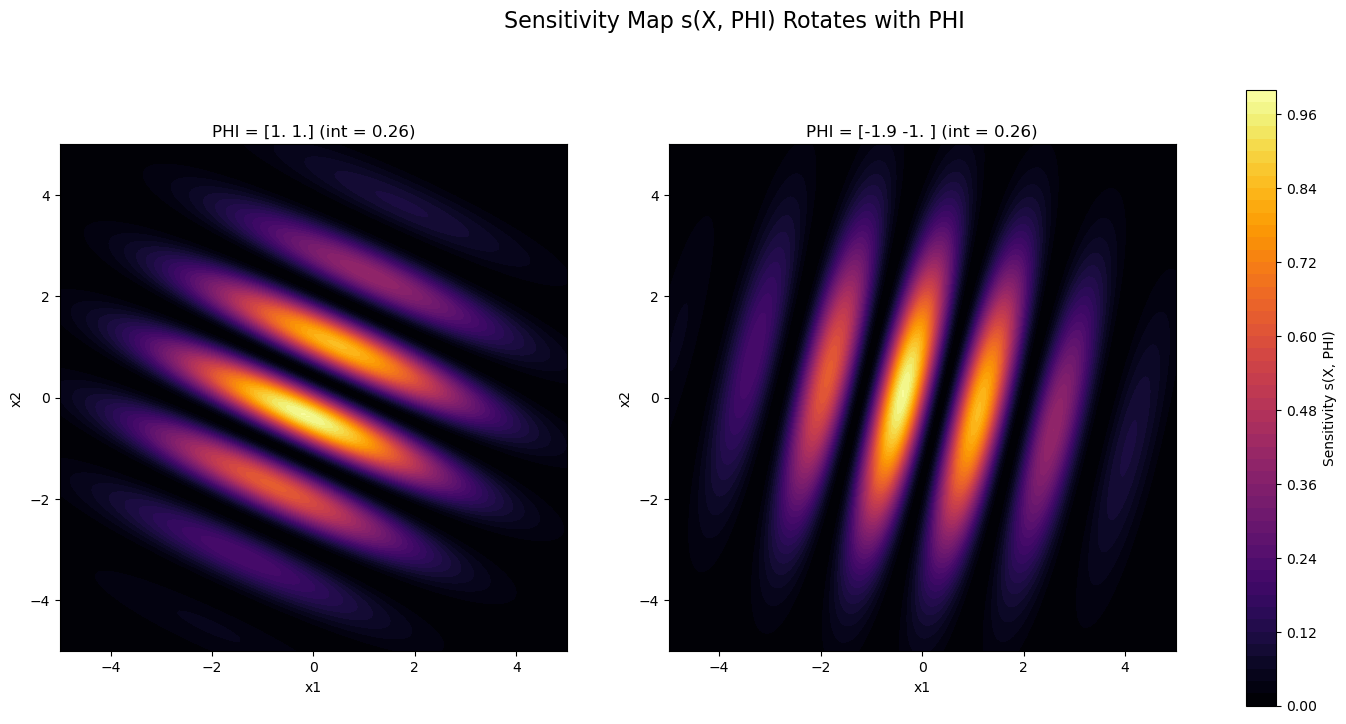

In [6]:
print("Generating visualization of the sensitivity map s(X, PHI)...")
fig_s, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig_s.suptitle("Sensitivity Map s(X, PHI) Rotates with PHI", fontsize=16)

# Plot for a non-rotated PHI
s_surface_opt = problem.sensitivity(phi_optimal.view(1,-1), X_vis).reshape(200, 200)
contour1 = ax1.contourf(xx1.numpy(), xx2.numpy(), s_surface_opt.numpy(), cmap='inferno', levels=50)
ax1.set_title(f'PHI = {np.round(phi_optimal.numpy(), 2)} (int = {problem._integrate_sensitivity(phi_optimal.view(1,-1)).item():.2f})')
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_aspect('equal')

# Plot for a rotated PHI
s_surface_rot = problem.sensitivity(phi_bad.view(1,-1), X_vis).reshape(200, 200)
ax2.contourf(xx1.numpy(), xx2.numpy(), s_surface_rot.numpy(), cmap='inferno', levels=50)
ax2.set_title(f'PHI = {np.round(phi_bad.numpy(), 2)} (int = {problem._integrate_sensitivity(phi_bad.view(1,-1)).item():.2f})')
ax2.set_xlabel('x1'); ax2.set_ylabel('x2'); ax2.set_aspect('equal')
fig_s.colorbar(contour1, ax=[ax1, ax2], label='Sensitivity s(X, PHI)')


# 2. Visualize the Hit Zone for different PHI values
print("Generating visualization of the 'Hit Zone' for different PHI values...")

plt.show()

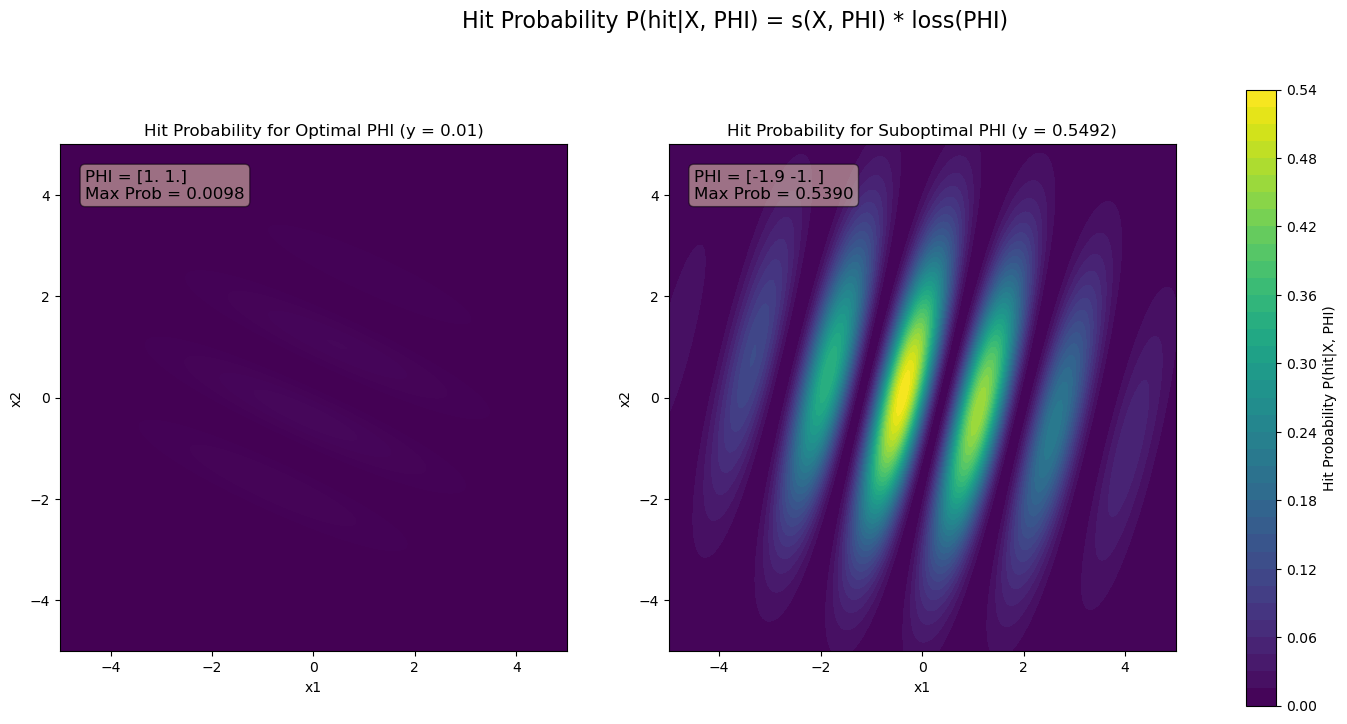

In [7]:
fig_hz, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig_hz.suptitle("Hit Probability P(hit|X, PHI) = s(X, PHI) * loss(PHI)", fontsize=16)

# Determine a common color scale for both plots
prob_opt = problem.probability_of_hit(phi_optimal.view(1,-1), X_vis)
prob_bad = problem.probability_of_hit(phi_bad.view(1,-1), X_vis)
vmax = max(prob_opt.max().item(), prob_bad.max().item())

for ax, phi, title in [(ax1, phi_optimal, f'Optimal PHI (y = {round(y_optimal, 4)})'), (ax2, phi_bad, f'Suboptimal PHI (y = {round(y_bad, 4)})')]:
    # Calculate the hit probability for every point in the visualization grid
    hit_prob_surface = problem.probability_of_hit(phi.view(1,-1), X_vis).reshape(200, 200).numpy()

    # Plot the hit probability surface
    contour_plot = ax.contourf(xx1.numpy(), xx2.numpy(), hit_prob_surface, cmap='viridis', levels=50, vmin=0, vmax=vmax)
    
    # Add text and labels
    max_prob = hit_prob_surface.max()
    ax.set_title(f'Hit Probability for {title}')
    ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_aspect('equal')
    ax.text(0.05, 0.95, f'PHI = {np.round(phi.numpy(), 2)}\nMax Prob = {max_prob:.4f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add a single, shared colorbar
fig_hz.colorbar(contour_plot, ax=[ax1, ax2], label='Hit Probability P(hit|X, PHI)')

plt.show()

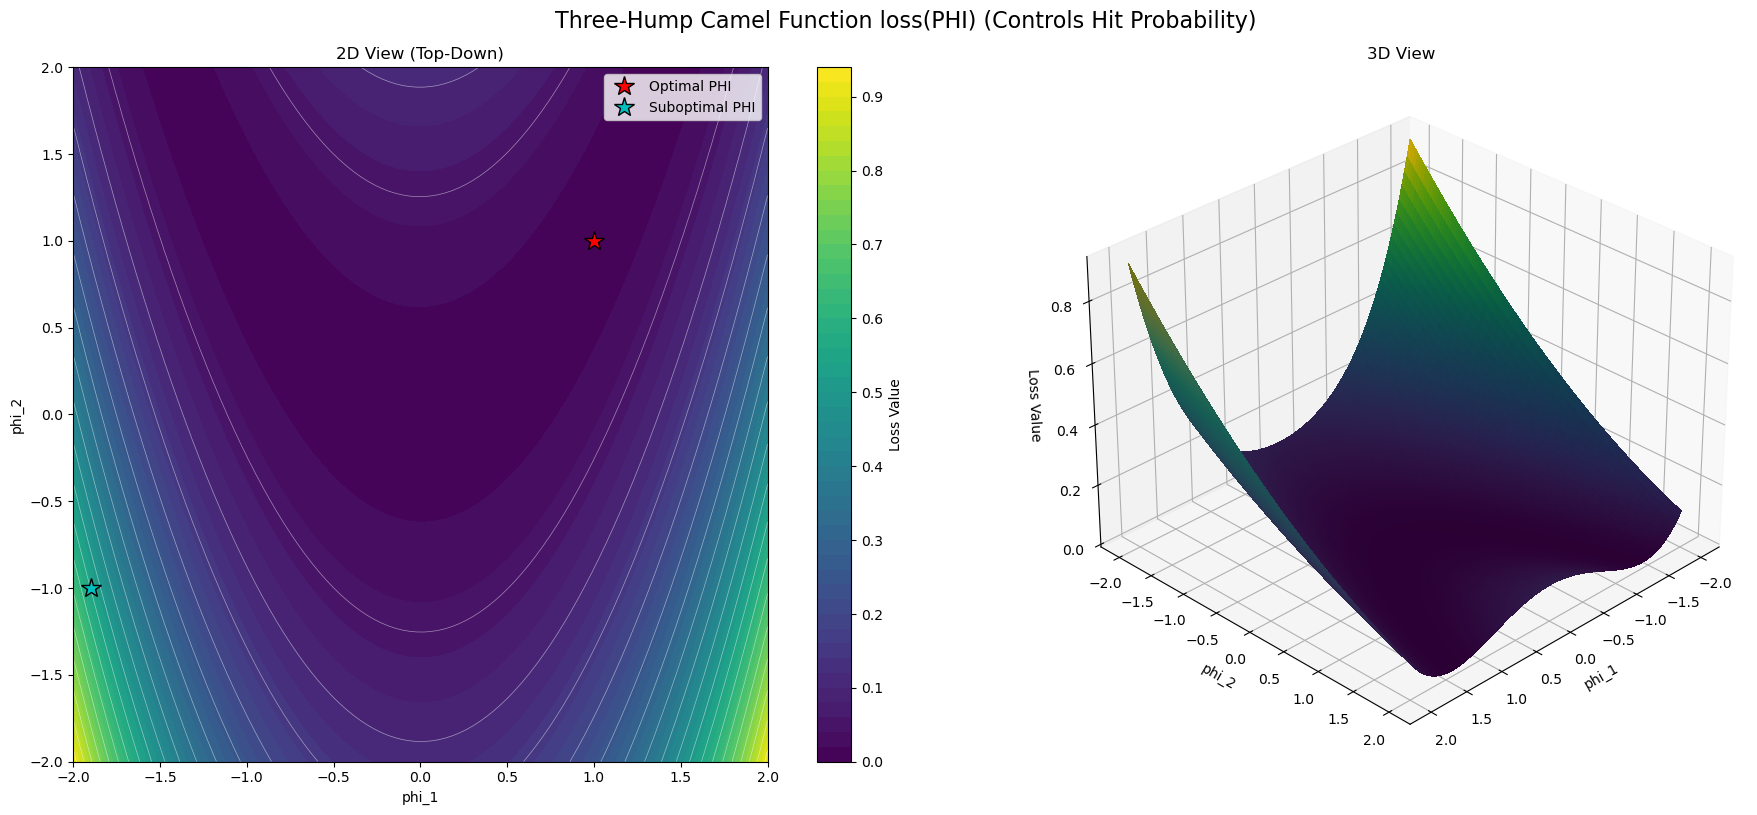

In [8]:

fig_g = plt.figure(figsize=(20, 8))
fig_g.suptitle("Three-Hump Camel Function loss(PHI) (Controls Hit Probability)", fontsize=16)

# Create grid for PHI domain
phi_bounds = problem.GetBounds()
pp1 = torch.linspace(phi_bounds[0, 0], phi_bounds[1, 0], 100)
pp2 = torch.linspace(phi_bounds[0, 1], phi_bounds[1, 1], 100)
pp1, pp2 = torch.meshgrid(pp1, pp2, indexing='ij')
phis = torch.stack([pp1.reshape(-1), pp2.reshape(-1)], dim=1)
g_surface = problem.loss(phis).reshape(100, 100).numpy()

# Left subplot: 2D Contour Plot
ax_2d = fig_g.add_subplot(1, 2, 1)
contour_g = ax_2d.contourf(pp1.numpy(), pp2.numpy(), g_surface, cmap='viridis', levels=50)
ax_2d.contour(pp1.numpy(), pp2.numpy(), g_surface, colors='white', alpha=0.5, levels=20, linewidths=0.5)
fig_g.colorbar(contour_g, ax=ax_2d, label='Loss Value')
ax_2d.set_title('2D View (Top-Down)')
ax_2d.set_xlabel('phi_1')
ax_2d.set_ylabel('phi_2')
ax_2d.set_aspect('equal')
# Mark the points for context
ax_2d.plot(phi_optimal[0], phi_optimal[1], 'r*', markersize=15, label='Optimal PHI', markeredgecolor='black')
ax_2d.plot(phi_bad[0], phi_bad[1], 'c*', markersize=15, label='Suboptimal PHI', markeredgecolor='black')
ax_2d.legend()

# Right subplot: 3D Surface Plot
ax_3d = fig_g.add_subplot(1, 2, 2, projection='3d')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(g_surface, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
ax_3d.plot_surface(pp1.numpy(), pp2.numpy(), g_surface, rstride=1, cstride=1, facecolors=rgb,
                linewidth=0, antialiased=False, zorder=0.5)
ax_3d.set_title('3D View')
ax_3d.set_xlabel('phi_1')
ax_3d.set_ylabel('phi_2')
ax_3d.set_zlabel('Loss Value')
ax_3d.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

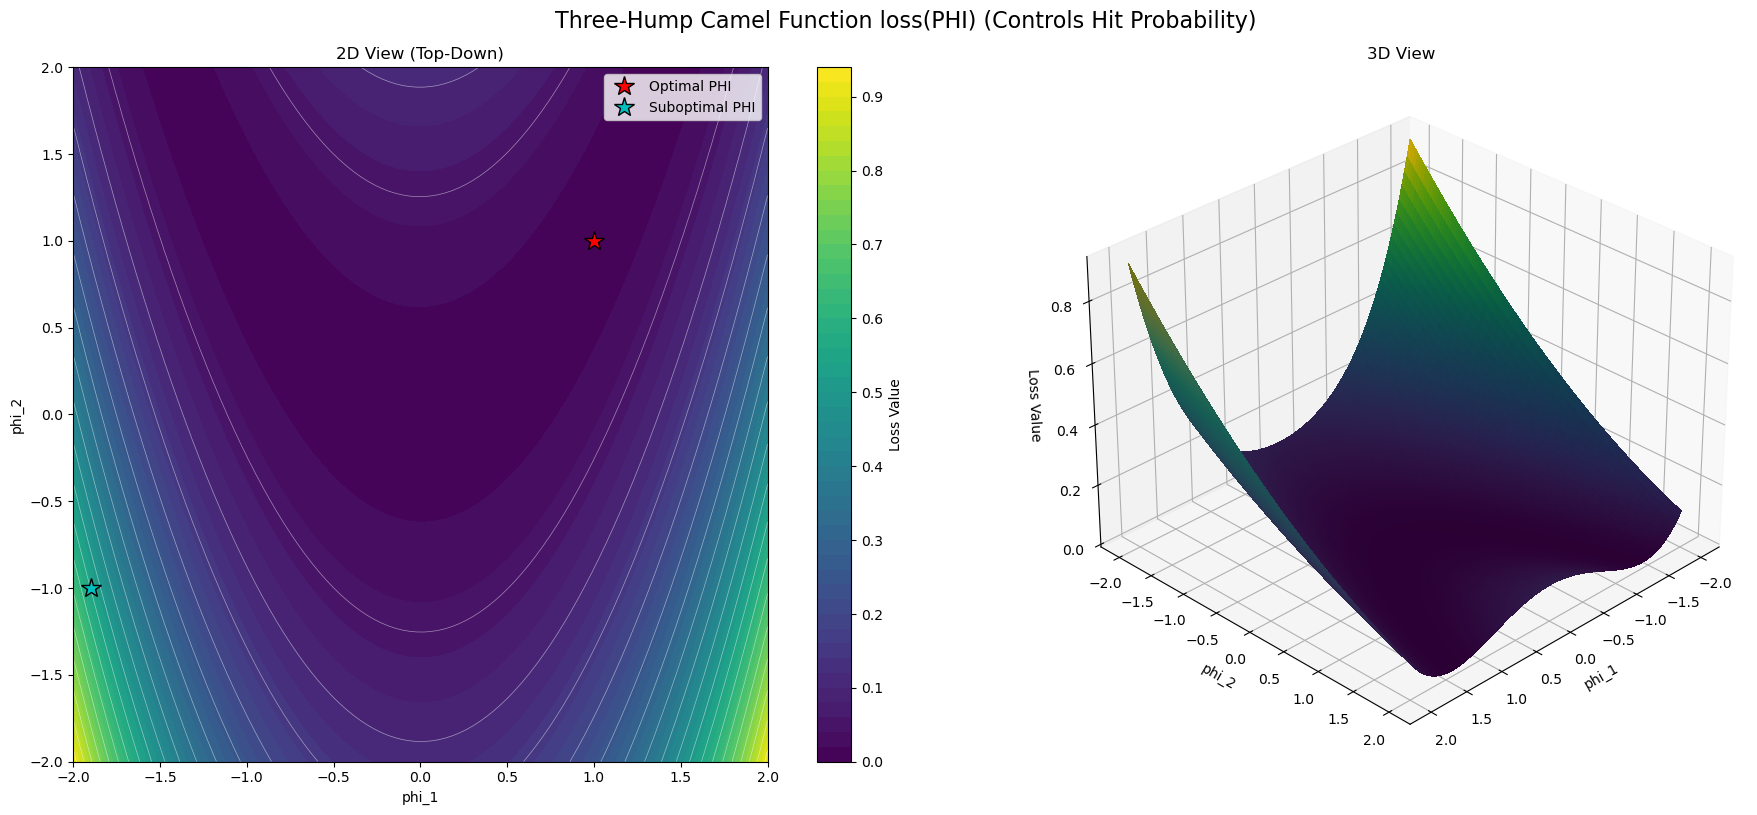

In [9]:
fig_g = plt.figure(figsize=(20, 8))
fig_g.suptitle("Three-Hump Camel Function loss(PHI) (Controls Hit Probability)", fontsize=16)

# Create grid for PHI domain
phi_bounds = problem.GetBounds()
pp1 = torch.linspace(phi_bounds[0, 0], phi_bounds[1, 0], 100)
pp2 = torch.linspace(phi_bounds[0, 1], phi_bounds[1, 1], 100)
pp1, pp2 = torch.meshgrid(pp1, pp2, indexing='ij')
phis = torch.stack([pp1.reshape(-1), pp2.reshape(-1)], dim=1)
g_surface = problem.loss(phis).reshape(100, 100).numpy()

# Left subplot: 2D Contour Plot
ax_2d = fig_g.add_subplot(1, 2, 1)
contour_g = ax_2d.contourf(pp1.numpy(), pp2.numpy(), g_surface, cmap='viridis', levels=50)
ax_2d.contour(pp1.numpy(), pp2.numpy(), g_surface, colors='white', alpha=0.5, levels=20, linewidths=0.5)
fig_g.colorbar(contour_g, ax=ax_2d, label='Loss Value')
ax_2d.set_title('2D View (Top-Down)')
ax_2d.set_xlabel('phi_1')
ax_2d.set_ylabel('phi_2')
ax_2d.set_aspect('equal')
# Mark the points for context
ax_2d.plot(phi_optimal[0], phi_optimal[1], 'r*', markersize=15, label='Optimal PHI', markeredgecolor='black')
ax_2d.plot(phi_bad[0], phi_bad[1], 'c*', markersize=15, label='Suboptimal PHI', markeredgecolor='black')
ax_2d.legend()

# Right subplot: 3D Surface Plot
ax_3d = fig_g.add_subplot(1, 2, 2, projection='3d')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(g_surface, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
ax_3d.plot_surface(pp1.numpy(), pp2.numpy(), g_surface, rstride=1, cstride=1, facecolors=rgb,
                linewidth=0, antialiased=False, zorder=0.5)
ax_3d.set_title('3D View')
ax_3d.set_xlabel('phi_1')
ax_3d.set_ylabel('phi_2')
ax_3d.set_zlabel('Loss Value')
ax_3d.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

Generating visualization of the gradient norm surface...


<Figure size 2000x800 with 0 Axes>

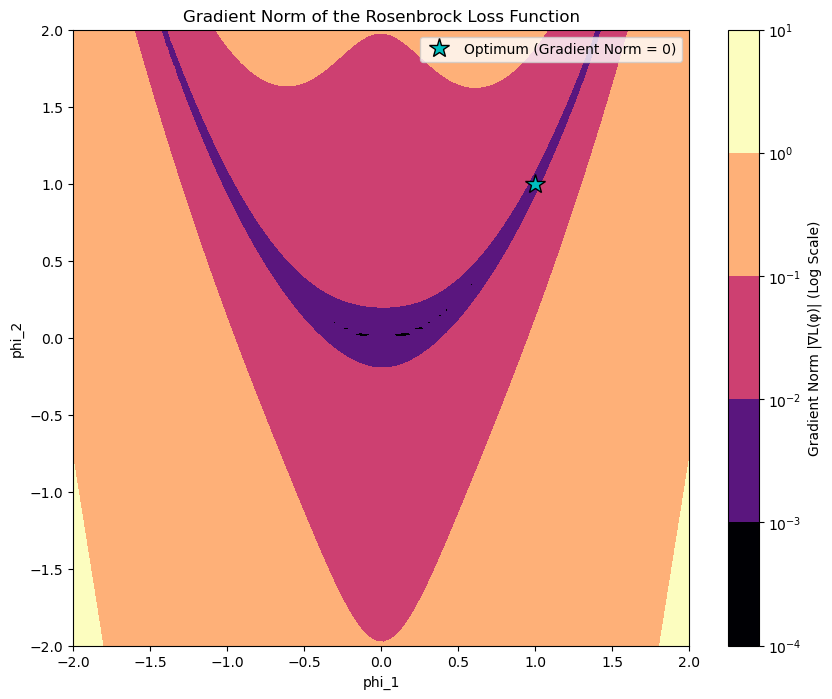

In [10]:
fig_g = plt.figure(figsize=(20, 8))
# --- Plotting the Gradient Norm ---
print("Generating visualization of the gradient norm surface...")

# Calculate gradient for each point in the grid
grads = problem.gradient(phis)
grad_norms = torch.norm(grads, dim=1)
grad_norm_surface = grad_norms.reshape(100, 100).detach().numpy()

# Create the plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Use a logarithmic scale for better visualization of the valley
# Add a small epsilon to avoid log(0)
norm = plt.cm.colors.LogNorm(vmin=grad_norm_surface.min() + 1e-4, vmax=grad_norm_surface.max())
contour = ax.contourf(pp1.numpy(), pp2.numpy(), grad_norm_surface, cmap='magma', levels=50, norm=norm)

plt.colorbar(contour, ax=ax, label='Gradient Norm |∇L(φ)| (Log Scale)')
ax.set_title('Gradient Norm of the Rosenbrock Loss Function')
ax.set_xlabel('phi_1')
ax.set_ylabel('phi_2')
ax.set_aspect('equal')

# Mark the optimal point where the gradient is zero
ax.plot(1, 1, 'c*', markersize=15, label='Optimum (Gradient Norm = 0)', markeredgecolor='black')
ax.legend()
plt.show()

In [1]:
# --- Create the new subplot figure ---
phis_grid = torch.stack([pp1.reshape(-1), pp2.reshape(-1)], dim=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle("Analysis of Rosenbrock Function's Derivatives", fontsize=16)

# --- Left Plot: Gradient Norm ---
print("Generating visualization of the gradient norm surface...")
grads = problem.gradient(phis_grid)
grad_norms = torch.norm(grads, dim=1)
grad_norm_surface = grad_norms.reshape(100, 100).detach().numpy()

# Use a logarithmic scale for better visualization of the valley
norm1 = plt.cm.colors.LogNorm(vmin=grad_norm_surface.min() + 1e-4, vmax=grad_norm_surface.max())
contour1 = ax1.contourf(pp1.numpy(), pp2.numpy(), grad_norm_surface, cmap='magma', levels=50, norm=norm1)
fig.colorbar(contour1, ax=ax1, label='Gradient Norm |∇L(φ)| (Log Scale)')

ax1.set_title('Gradient Norm')
ax1.set_xlabel('phi_1')
ax1.set_ylabel('phi_2')
ax1.set_aspect('equal')
ax1.plot(1, 1, 'c*', markersize=15, label='Optimum (Gradient Norm = 0)', markeredgecolor='black')
ax1.legend()


# --- Right Plot: Condition Number of the Hessian ---
print("Generating visualization of the Hessian Condition Number...")
condition_number_surface = np.zeros_like(grad_norm_surface)

for i in range(phis_grid.shape[0]):
    phi_point = phis_grid[i]
    try:
        hess = problem.hessian(phi_point)
        # Calculate eigenvalues for the symmetric Hessian
        eigenvalues = torch.linalg.eigvalsh(hess)
        lambda_min, lambda_max = eigenvalues[0], eigenvalues[-1]
        
        # Avoid division by zero and handle non-positive definite cases
        if lambda_min > 1e-6: # Check if matrix is positive definite
            condition_number = (lambda_max / lambda_min).item()
            condition_number_surface.flat[i] = condition_number
        else:
            condition_number_surface.flat[i] = np.nan # Mark singular/indefinite
    except torch.linalg.LinAlgError:
        condition_number_surface.flat[i] = np.nan

# Use a logarithmic scale to handle the wide range of condition numbers
valid_conds = condition_number_surface[~np.isnan(condition_number_surface)]
if len(valid_conds) > 0:
    vmin_cond = np.min(valid_conds)
    vmax_cond = np.max(valid_conds)
    norm2 = plt.cm.colors.LogNorm(vmin=max(vmin_cond, 1e-12), vmax=vmax_cond)
    
    contour2 = ax2.contourf(pp1.numpy(), pp2.numpy(), condition_number_surface, cmap='cividis', levels=50, norm=norm2)
    fig.colorbar(contour2, ax=ax2, label='Hessian Condition Number κ(H) (Log Scale)')
else:
    ax2.text(0.5, 0.5, 'Condition number calculation failed for all points', ha='center', va='center')

ax2.set_title('Hessian Condition Number (Ill-Conditioning)')
ax2.set_xlabel('phi_1')
ax2.set_ylabel('phi_2')
ax2.set_aspect('equal')
ax2.plot(1, 1, 'r*', markersize=15, label='Optimum', markeredgecolor='black')
ax2.legend()

# Final adjustments and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'torch' is not defined